# Homework 2 AS4501-1

Course Instructor: Francisco Förster

Author: Álvaro Cáceres

In [1]:
## Importing libraries


# Recommended libraries

import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import corner
import astropy.units as u 
import astropy.cosmology
import dill

# Configs

pd.set_option('display.max_rows', 10)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore") 

# Machine Learning libraries

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# Visualization

from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec


# Import and initialize the ALeRCE client
from alerce.core import Alerce
alerce = Alerce()

Modern astronomical surveys, such as the **Zwicky Transient Facility (ZTF)** and the upcoming **Vera C. Rubin Observatory** with its **Legacy Survey of Space and Time (LSST)**, are transforming our understanding of the variable sky. These telescopes generate continuous streams of **real-time alerts** for new or variable celestial objects, producing massive amounts of data that require automated processing.

To address this challenge, several **astronomical alert brokers** have been developed, including **ALeRCE (Automatic Learning for the Rapid Classification of Events)**, a Chilean community broker for LSST. These systems use **machine learning** techniques to classify transient events efficiently.

In this project, we aim to implement a simplified version of an ALeRCE-like **alert classifier** using **pandas** and **scikit-learn**, exploring how data manipulation and machine learning can be applied to real-time astronomical data analysis.

## Data curation

The goal here is to load and visualize a small dataset (`dfcrossmatches_small.pickle`) that contains information about astronomical objects and their corresponding ALeRCE class labels.
We will perform a few simple but efficient operations in one line each, as required.

,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec
oid,,,,,,,,
ZTF18aaveffj,LPV,291.520423,21.930962,NaN,GAIADR2VS,2018953972876187648.0,MIRA_SR,0.067312
ZTF19aauyvnv,LPV,270.298238,-17.722810,NaN,GAIADR2VS,4143774487177066496.0,MIRA_SR,0.062104
ZTF18ablqvvc,RRL,271.180157,-6.556286,NaN,GAIADR2VS,4171403011041441792.0,RRAB,0.095138
ZTF19abiblfd,RRL,268.188213,-17.161156,NaN,GAIADR2VS,4144758786310249984.0,RRAB,0.043913
ZTF18acbvvku,AGN,48.110790,39.274936,NaN,MILLIQUAS,4C 39.11,A,0.055433
...,...,...,...,...,...,...,...,...
ZTF18aawgtde,QSO,235.612689,29.700747,NaN,MILLIQUAS,FBQS J1542+2942,Q,0.384536
ZTF18ablqnie,LPV,260.850159,-23.237702,NaN,GAIADR2VS,4111611813625888768.0,MIRA_SR,0.228594
ZTF19adcftsl,QSO,210.322714,22.715302,NaN,MILLIQUAS,LAMOSTJ140117.45+224255.2,Q,0.067727


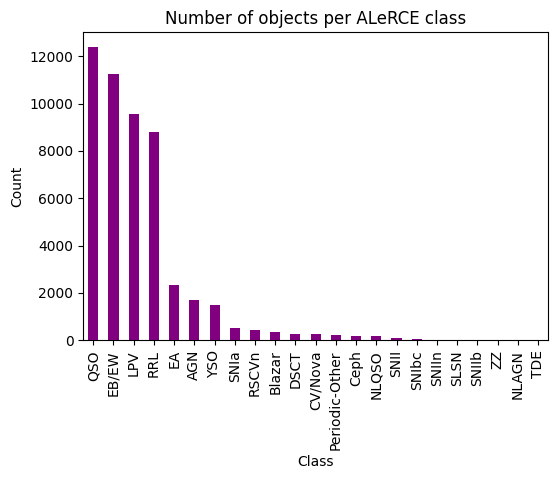

In [2]:
# Read the dataframe
df = pd.read_pickle('dfcrossmatches_small.pickle')

# Display the dataframe
display(df)

# Extract only the 'classALeRCE' column
classes = df['classALeRCE']

# Plot the number of objects per class as a bar plot
classes.value_counts().plot.bar(figsize=(6,4), title='Number of objects per ALeRCE class', color = "purple")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

As we can see the dataframe contains ZTF objects cross-matched with external catalogs such as GAIA DR2 and MILLIQUAS. Each entry includes coordinates (RA, Dec), class labels from ALeRCE, and match information. The most common classes are QSO, EB/EW, LPV, and RRL, showing a mix of quasars, eclipsing binaries, and variable stars. Small separation values (<0.1″) indicate accurate crossmatches between surveys.

Now we will read and reshape the "`features_small.pickle`" dataframe so that each feature and filter band (fid) becomes a column

In [3]:
# Read the features dataframe 
features = pd.read_pickle('features_small.pickle')

# Display it 
display(features)

# Pivot the table: columns from 'name' and 'fid', values from 'value' 
features_pivot = features.pivot(columns=['name', 'fid'], values='value')

# Display the pivoted dataframe 
display(features_pivot)

,name,value,fid,version
oid,,,,
ZTF17aaaabrg,Amplitude,0.242504,1,feature_0.0.1
ZTF17aaaabrg,Amplitude,0.232499,2,feature_0.0.1
ZTF17aaaabrg,AndersonDarling,1.000000,1,feature_0.0.1
ZTF17aaaabrg,AndersonDarling,1.000000,2,feature_0.0.1
ZTF17aaaabrg,Autocor_length,1.000000,1,feature_0.0.1
...,...,...,...,...
ZTF21abkylyc,Std,0.239856,2,feature_0.0.1
ZTF21abkylyc,StetsonK,NaN,1,feature_0.0.1
ZTF21abkylyc,StetsonK,0.886870,2,feature_0.0.1


name         Amplitude           AndersonDarling           Autocor_length  \
fid                 1         2               1         2              1    
oid                                                                         
ZTF17aaaabrg  0.242504  0.232499        1.000000  1.000000            1.0   
ZTF17aaaabtj  0.294114  0.216206        1.000000  1.000000            1.0   
ZTF17aaaacml  0.179008  0.162632        1.000000  1.000000            1.0   
ZTF17aaaacnc  0.199403  0.215955        1.000000  0.999978            1.0   
ZTF17aaaacnt  0.671062  0.498549        1.000000  0.775576            1.0   
...                ...       ...             ...       ...            ...   
ZTF21abkjyui  0.683250       NaN        0.677959       NaN            1.0   
ZTF21abkndcw  0.617332       NaN        0.989514       NaN            1.0   
ZTF21abknlix  0.077879  0.075038        0.520365  0.386736            3.0   
ZTF21abkrimu       NaN  0.402185             NaN  1.000000            NaN   
ZTF21abkylyc       NaN  0.369650             NaN  0.576287            NaN   

name              Beyond1Std            Con            ...       Std  \
fid            2          1         2    1         2   ...        2    
oid                                                    ...             
ZTF17aaaabrg  1.0   0.426471  0.361446  0.0  0.000000  ...  0.164944   
ZTF17aaaabtj  1.0   0.489510  0.390909  0.0  0.009259  ...  0.119271   
ZTF17aaaacml  1.0   0.403846  0.229508  0.0  0.000000  ...  0.115176   
ZTF17aaaacnc  1.0   0.062500  0.350000  0.0  0.000000  ...  0.102518   
ZTF17aaaacnt  1.0   0.242105  0.298246  0.0  0.000000  ...  0.271919   
...           ...        ...       ...  ...       ...  ...       ...   
ZTF21abkjyui  NaN   0.333333       NaN  0.0       NaN  ...       NaN   
ZTF21abkndcw  NaN   0.166667       NaN  0.0       NaN  ...       NaN   
ZTF21abknlix  1.0   0.416667  0.285714  0.0  0.000000  ...  0.048887   
ZTF21abkrimu  1.0        NaN  0.322581  NaN  0.000000  ...  0.268336   
ZTF21abkylyc  1.0        NaN  0.250000  NaN  0.000000  ...  0.239856   

name          StetsonK                g-W2      g-W3 Power_rate      r-W2  \
fid                 1         2         0         0          12        0    
oid                                                                         
ZTF17aaaabrg  0.912734  0.958511       NaN       NaN        NaN       NaN   
ZTF17aaaabtj  0.967987  0.758365       NaN       NaN        NaN       NaN   
ZTF17aaaacml  0.946447  0.786144       NaN       NaN        NaN       NaN   
ZTF17aaaacnc  0.525565  0.786877       NaN       NaN        NaN       NaN   
ZTF17aaaacnt  0.820105  0.772239       NaN       NaN        NaN       NaN   
...                ...       ...       ...       ...        ...       ...   
ZTF21abkjyui  0.808906       NaN       NaN       NaN   0.000866       NaN   
ZTF21abkndcw  0.777093       NaN  2.248809  4.216808   0.000090  1.479431   
ZTF21abknlix  0.839430  0.776154  8.182998  8.388997   0.053091  5.690223   
ZTF21abkrimu       NaN  0.850610       NaN       NaN   0.002877       NaN   
ZTF21abkylyc       NaN  0.886870       NaN       NaN   0.184779       NaN   

name              r-W3     W1-W2     W2-W3  
fid                 0         0         0   
oid                                         
ZTF17aaaabrg       NaN       NaN       NaN  
ZTF17aaaabtj       NaN       NaN       NaN  
ZTF17aaaacml       NaN       NaN       NaN  
ZTF17aaaacnc       NaN       NaN       NaN  
ZTF17aaaacnt       NaN       NaN       NaN  
...                ...       ...       ...  
ZTF21abkjyui       NaN       NaN       NaN  
ZTF21abkndcw  3.447430 -0.316000  1.967999  
ZTF21abknlix  5.896222  0.051001  0.205999  
ZTF21abkrimu       NaN       NaN       NaN  
ZTF21abkylyc       NaN       NaN       NaN  

[39024 rows x 179 columns]

After reading and reshaping the datasets, we obtained a structured view of the features associated with each astronomical object. The pivot operation successfully transformed the original long-format table into a wide-format dataframe, where each row corresponds to one object (`oid`) and each column represents a specific feature measured in a given photometric band (`fid`).

We can access data from the resulting MultiIndex columns like this:

In [4]:
# Example: get the 'amplitude' feature in band 1 for all objects
features_pivot[('Amplitude', 1)].head()

oid
ZTF17aaaabrg    0.242504
ZTF17aaaabtj    0.294114
ZTF17aaaacml    0.179008
ZTF17aaaacnc    0.199403
ZTF17aaaacnt    0.671062
Name: (Amplitude, 1), dtype: float64

In [5]:
# Example: get the amplitude in band 1 for a specific oid
features_pivot.loc['ZTF17aaaabrg', ('Amplitude', 1)]

np.float64(0.24250411987304688)

Now we want to compute the **median** of each column and use it to fill missing values in the features dataframe.

In [6]:
# Display the median of every column
display(features_pivot.median())

# Replace NaN values with the median of each column
features_filled = features_pivot.fillna(features_pivot.median())

# Display the cleaned dataframe
display(features_filled)

name             fid
Amplitude        1      0.402083
                 2      0.341036
AndersonDarling  1      0.999934
                 2      0.999747
Autocor_length   1      1.000000
                          ...   
Power_rate       12     0.029785
r-W2             0      4.645677
r-W3             0      7.501856
W1-W2            0      0.559000
W2-W3            0      2.527000
Length: 179, dtype: float64

name         Amplitude           AndersonDarling           Autocor_length  \
fid                 1         2               1         2              1    
oid                                                                         
ZTF17aaaabrg  0.242504  0.232499        1.000000  1.000000            1.0   
ZTF17aaaabtj  0.294114  0.216206        1.000000  1.000000            1.0   
ZTF17aaaacml  0.179008  0.162632        1.000000  1.000000            1.0   
ZTF17aaaacnc  0.199403  0.215955        1.000000  0.999978            1.0   
ZTF17aaaacnt  0.671062  0.498549        1.000000  0.775576            1.0   
...                ...       ...             ...       ...            ...   
ZTF21abkjyui  0.683250  0.341036        0.677959  0.999747            1.0   
ZTF21abkndcw  0.617332  0.341036        0.989514  0.999747            1.0   
ZTF21abknlix  0.077879  0.075038        0.520365  0.386736            3.0   
ZTF21abkrimu  0.402083  0.402185        0.999934  1.000000            1.0   
ZTF21abkylyc  0.402083  0.369650        0.999934  0.576287            1.0   

name              Beyond1Std            Con            ...       Std  \
fid            2          1         2    1         2   ...        2    
oid                                                    ...             
ZTF17aaaabrg  1.0   0.426471  0.361446  0.0  0.000000  ...  0.164944   
ZTF17aaaabtj  1.0   0.489510  0.390909  0.0  0.009259  ...  0.119271   
ZTF17aaaacml  1.0   0.403846  0.229508  0.0  0.000000  ...  0.115176   
ZTF17aaaacnc  1.0   0.062500  0.350000  0.0  0.000000  ...  0.102518   
ZTF17aaaacnt  1.0   0.242105  0.298246  0.0  0.000000  ...  0.271919   
...           ...        ...       ...  ...       ...  ...       ...   
ZTF21abkjyui  1.0   0.333333  0.325000  0.0  0.000000  ...  0.212839   
ZTF21abkndcw  1.0   0.166667  0.325000  0.0  0.000000  ...  0.212839   
ZTF21abknlix  1.0   0.416667  0.285714  0.0  0.000000  ...  0.048887   
ZTF21abkrimu  1.0   0.329268  0.322581  0.0  0.000000  ...  0.268336   
ZTF21abkylyc  1.0   0.329268  0.250000  0.0  0.000000  ...  0.239856   

name          StetsonK                g-W2      g-W3 Power_rate      r-W2  \
fid                 1         2         0         0          12        0    
oid                                                                         
ZTF17aaaabrg  0.912734  0.958511  4.943869  7.820271   0.029785  4.645677   
ZTF17aaaabtj  0.967987  0.758365  4.943869  7.820271   0.029785  4.645677   
ZTF17aaaacml  0.946447  0.786144  4.943869  7.820271   0.029785  4.645677   
ZTF17aaaacnc  0.525565  0.786877  4.943869  7.820271   0.029785  4.645677   
ZTF17aaaacnt  0.820105  0.772239  4.943869  7.820271   0.029785  4.645677   
...                ...       ...       ...       ...        ...       ...   
ZTF21abkjyui  0.808906  0.825233  4.943869  7.820271   0.000866  4.645677   
ZTF21abkndcw  0.777093  0.825233  2.248809  4.216808   0.000090  1.479431   
ZTF21abknlix  0.839430  0.776154  8.182998  8.388997   0.053091  5.690223   
ZTF21abkrimu  0.834742  0.850610  4.943869  7.820271   0.002877  4.645677   
ZTF21abkylyc  0.834742  0.886870  4.943869  7.820271   0.184779  4.645677   

name              r-W3     W1-W2     W2-W3  
fid                 0         0         0   
oid                                         
ZTF17aaaabrg  7.501856  0.559000  2.527000  
ZTF17aaaabtj  7.501856  0.559000  2.527000  
ZTF17aaaacml  7.501856  0.559000  2.527000  
ZTF17aaaacnc  7.501856  0.559000  2.527000  
ZTF17aaaacnt  7.501856  0.559000  2.527000  
...                ...       ...       ...  
ZTF21abkjyui  7.501856  0.559000  2.527000  
ZTF21abkndcw  3.447430 -0.316000  1.967999  
ZTF21abknlix  5.896222  0.051001  0.205999  
ZTF21abkrimu  7.501856  0.559000  2.527000  
ZTF21abkylyc  7.501856  0.559000  2.527000  

[39024 rows x 179 columns]

Replacing missing values with the column median ensures that all features can be used in subsequent analyses without introducing biases from arbitrary imputation. After this step, the dataset becomes numerically consistent and ready for normalization and machine learning classification.

In order to train a supervised machine learning model, each object must have both its measured features and its corresponding class label. Concatenating the features dataframe with the class labels aligns the data by object identifier (`oid`), creating a unified dataset. This step is crucial because missing features or labels would prevent the model from learning effectively, and it allows us to remove incomplete rows before training.

In [7]:
# Concatenate classes (Series) with features (DataFrame) along columns
df_final = pd.concat([classes, features_filled], axis=1)

# Display the result
display(df_final)

# Drop rows with NaN values (inplace=True)
df_final.dropna(inplace=True)

# Display the cleaned dataframe
display(df_final)


,classALeRCE,"(Amplitude, 1)","(Amplitude, 2)","(AndersonDarling, 1)","(AndersonDarling, 2)","(Autocor_length, 1)","(Autocor_length, 2)","(Beyond1Std, 1)","(Beyond1Std, 2)","(Con, 1)",...,"(Std, 2)","(StetsonK, 1)","(StetsonK, 2)","(g-W2, 0)","(g-W3, 0)","(Power_rate, 12)","(r-W2, 0)","(r-W3, 0)","(W1-W2, 0)","(W2-W3, 0)"
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aaveffj,LPV,0.264278,0.363577,0.999210,1.000000,6.0,6.0,0.248276,0.442424,0.006993,...,0.195895,0.808636,0.822968,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF19aauyvnv,LPV,0.402083,0.341036,0.999934,0.999747,1.0,1.0,0.329268,0.325000,0.000000,...,0.212839,0.834742,0.825233,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF18ablqvvc,RRL,0.402083,0.100148,0.999934,0.621504,1.0,1.0,0.329268,0.266667,0.000000,...,0.053437,0.834742,0.821775,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF19abiblfd,RRL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18acbvvku,AGN,0.849506,0.653158,1.000000,1.000000,12.0,9.0,0.404494,0.293103,0.000000,...,0.405141,0.909260,0.886437,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18aawgtde,QSO,0.072512,0.064309,0.684191,0.779616,11.0,1.0,0.315217,0.250000,0.000000,...,0.035427,0.819063,0.758283,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF18ablqnie,LPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF19adcftsl,QSO,0.183510,0.341036,0.805664,0.999747,2.0,1.0,0.368421,0.325000,0.000000,...,0.212839,0.861115,0.825233,5.867576,9.412576,0.004110,5.385038,8.930038,1.265,3.545


,classALeRCE,"(Amplitude, 1)","(Amplitude, 2)","(AndersonDarling, 1)","(AndersonDarling, 2)","(Autocor_length, 1)","(Autocor_length, 2)","(Beyond1Std, 1)","(Beyond1Std, 2)","(Con, 1)",...,"(Std, 2)","(StetsonK, 1)","(StetsonK, 2)","(g-W2, 0)","(g-W3, 0)","(Power_rate, 12)","(r-W2, 0)","(r-W3, 0)","(W1-W2, 0)","(W2-W3, 0)"
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aaveffj,LPV,0.264278,0.363577,0.999210,1.000000,6.0,6.0,0.248276,0.442424,0.006993,...,0.195895,0.808636,0.822968,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF19aauyvnv,LPV,0.402083,0.341036,0.999934,0.999747,1.0,1.0,0.329268,0.325000,0.000000,...,0.212839,0.834742,0.825233,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF18ablqvvc,RRL,0.402083,0.100148,0.999934,0.621504,1.0,1.0,0.329268,0.266667,0.000000,...,0.053437,0.834742,0.821775,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF18acbvvku,AGN,0.849506,0.653158,1.000000,1.000000,12.0,9.0,0.404494,0.293103,0.000000,...,0.405141,0.909260,0.886437,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF18acefhus,QSO,0.178364,0.192065,0.999954,0.999975,5.0,6.0,0.294872,0.244898,0.000000,...,0.085607,0.739245,0.714789,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF19aarauin,RRL,0.587070,0.565650,0.999999,1.000000,2.0,2.0,0.413793,0.351351,0.000000,...,0.319543,0.888937,0.912618,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF18aawgtde,QSO,0.072512,0.064309,0.684191,0.779616,11.0,1.0,0.315217,0.250000,0.000000,...,0.035427,0.819063,0.758283,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF19adcftsl,QSO,0.183510,0.341036,0.805664,0.999747,2.0,1.0,0.368421,0.325000,0.000000,...,0.212839,0.861115,0.825233,5.867576,9.412576,0.004110,5.385038,8.930038,1.265,3.545


After concatenating the class labels with the feature dataframe using `pd.concat(axis=1)`, we obtained a unified dataset where each row corresponds to one object (`oid`) with its associated features and class label. Rows with missing values, corresponding to objects lacking complete feature information, were removed using `dropna()`. This ensures that the final dataset is consistent and suitable for training supervised machine learning models without introducing incomplete entries.

Creating a bar plot of the number of objects per class helps to visualize how the concatenation and cleaning steps affected the dataset. By examining this distribution, we can quickly identify which classes are most represented and assess the impact of removing rows with missing values. This visualization provides insight into the dataset’s balance, which is crucial for training a reliable classifier.

<Axes: title={'center': 'Number of objects per class'}, xlabel='classALeRCE'>

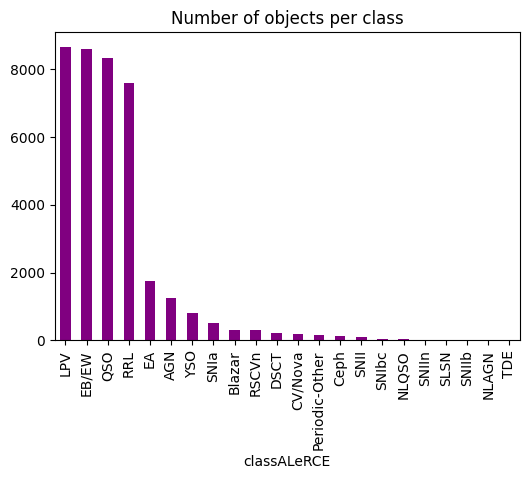

In [8]:
# We do a bar plot
df_final['classALeRCE'].value_counts().plot.bar(title='Number of objects per class', color="purple",  figsize=(6,4))

The new bar plot shows that the distribution among the most represented classes became more uniform, with roughly the same number of objects for each of the top four classes. The order of these classes also changed slightly. For the less common classes, the distribution remains similar to the original. Overall, the total number of objects decreased from about 50,000 to approximately 39,000 due to the removal of incomplete rows, which is reflected in the reduced scale of the plot.

In this step, we simplify and clean the dataset by merging related classes and removing irrelevant or underrepresented ones. Grouping “EB/EW” and “EA” into a single class “EB” consolidates all eclipsing binary types, making the classification problem more coherent. Additionally, dropping classes such as “NLAGN”, “NLQSO”, “TDE”, and “ZZ” helps to focus on the most relevant stellar types and reduces noise in the dataset, improving the quality of the subsequent model training.

In [9]:
# Group the classes "EB/EW" and "EA" as "EB"
df_final['classALeRCE'].replace({'EB/EW': 'EB', 'EA': 'EB'}, inplace=True)

# Drop the classes "NLAGN", "NLQSO", "TDE" and "ZZ"
df_final = df_final.loc[~df_final['classALeRCE'].isin(['NLAGN', 'NLQSO', 'TDE', 'ZZ'])]

# Display the resulting dataframe
display(df_final)

,classALeRCE,"(Amplitude, 1)","(Amplitude, 2)","(AndersonDarling, 1)","(AndersonDarling, 2)","(Autocor_length, 1)","(Autocor_length, 2)","(Beyond1Std, 1)","(Beyond1Std, 2)","(Con, 1)",...,"(Std, 2)","(StetsonK, 1)","(StetsonK, 2)","(g-W2, 0)","(g-W3, 0)","(Power_rate, 12)","(r-W2, 0)","(r-W3, 0)","(W1-W2, 0)","(W2-W3, 0)"
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aaveffj,LPV,0.264278,0.363577,0.999210,1.000000,6.0,6.0,0.248276,0.442424,0.006993,...,0.195895,0.808636,0.822968,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF19aauyvnv,LPV,0.402083,0.341036,0.999934,0.999747,1.0,1.0,0.329268,0.325000,0.000000,...,0.212839,0.834742,0.825233,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF18ablqvvc,RRL,0.402083,0.100148,0.999934,0.621504,1.0,1.0,0.329268,0.266667,0.000000,...,0.053437,0.834742,0.821775,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF18acbvvku,AGN,0.849506,0.653158,1.000000,1.000000,12.0,9.0,0.404494,0.293103,0.000000,...,0.405141,0.909260,0.886437,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF18acefhus,QSO,0.178364,0.192065,0.999954,0.999975,5.0,6.0,0.294872,0.244898,0.000000,...,0.085607,0.739245,0.714789,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF19aarauin,RRL,0.587070,0.565650,0.999999,1.000000,2.0,2.0,0.413793,0.351351,0.000000,...,0.319543,0.888937,0.912618,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF18aawgtde,QSO,0.072512,0.064309,0.684191,0.779616,11.0,1.0,0.315217,0.250000,0.000000,...,0.035427,0.819063,0.758283,4.943869,7.820271,0.029785,4.645677,7.501856,0.559,2.527
ZTF19adcftsl,QSO,0.183510,0.341036,0.805664,0.999747,2.0,1.0,0.368421,0.325000,0.000000,...,0.212839,0.861115,0.825233,5.867576,9.412576,0.004110,5.385038,8.930038,1.265,3.545


After merging and removing the specified classes, the dataset becomes more consistent and easier to handle. The class structure is now clearer, with fewer overlapping categories and a more balanced representation of the remaining ones. This cleaning step ensures that the design matrix 
$\Chi$ and the label vector 
$y$ will be based on a well-defined and homogeneous set of stellar classes, facilitating better classification performance and interpretability in the following stages.

Scaling the features ensures that all variables contribute equally in future model training. Features with large numerical ranges can dominate those with smaller ranges, so standardization is applied to make the dataset more uniform and comparable.

In [10]:
# Scale the features (all columns except the class label)
scaler = StandardScaler()
features_scaled = pd.DataFrame(
    scaler.fit_transform(df_final.drop(columns='classALeRCE')),
    columns=df_final.drop(columns='classALeRCE').columns,
    index=df_final.index
)

# Display the first rows
display(features_scaled)

,"(Amplitude, 1)","(Amplitude, 2)","(AndersonDarling, 1)","(AndersonDarling, 2)","(Autocor_length, 1)","(Autocor_length, 2)","(Beyond1Std, 1)","(Beyond1Std, 2)","(Con, 1)","(Con, 2)",...,"(Std, 2)","(StetsonK, 1)","(StetsonK, 2)","(g-W2, 0)","(g-W3, 0)","(Power_rate, 12)","(r-W2, 0)","(r-W3, 0)","(W1-W2, 0)","(W2-W3, 0)"
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aaveffj,-0.543779,-0.194962,0.490355,0.497912,0.946605,1.022125,-0.843800,1.291768,0.552118,3.350947,...,-0.290147,-0.306845,0.009640,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
ZTF19aauyvnv,-0.236602,-0.252409,0.493883,0.496688,-0.412377,-0.373345,-0.022339,0.002728,-0.218764,-0.207622,...,-0.217913,0.027814,0.038247,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
ZTF18ablqvvc,-0.236602,-0.866313,0.493883,-1.335834,-0.412377,-0.373345,-0.022339,-0.637633,-0.218764,-0.207622,...,-0.897484,0.027814,-0.005425,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
ZTF18acbvvku,0.760736,0.543036,0.494203,0.497912,2.577384,1.859406,0.740638,-0.347420,-0.218764,-0.207622,...,0.601921,0.983089,0.811314,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
ZTF18acefhus,-0.735287,-0.632062,0.493976,0.497789,0.674809,1.022125,-0.371203,-0.876602,-0.218764,3.417670,...,-0.760336,-1.196399,-1.356767,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF19aarauin,0.175746,0.320021,0.494198,0.497912,-0.140580,-0.094251,0.834950,0.292004,-0.218764,-0.207622,...,0.236995,0.722562,1.142002,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
ZTF18aawgtde,-0.971240,-0.957649,-1.043126,-0.569812,2.305588,-0.373345,-0.164849,-0.820594,-0.218764,-0.207622,...,-0.974266,-0.173175,-0.807399,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
ZTF19adcftsl,-0.723817,-0.252409,-0.451805,0.496688,-0.140580,-0.373345,0.374766,0.002728,-0.218764,-0.207622,...,-0.217913,0.365902,0.038247,0.994897,1.727795,-0.413335,0.992527,1.690718,3.340415,2.211659


After scaling, all feature columns have a mean of 0 and a standard deviation of 1. This ensures that all variables are on the same scale, which is crucial for many machine learning algorithms, particularly those sensitive to the magnitude of features. The relative distribution and correlations between features are preserved, but extreme differences in scale are removed.

Before training a machine learning model, the dataset must be separated into features (design matrix $\Chi$) and target labels ($y$). $\Chi$ contains the scaled numerical features describing each object, while $y$ contains the class labels. This separation is essential for supervised learning algorithms, which use $\Chi$ to learn patterns and $y$ to provide the ground truth.

In [11]:
# Design matrix X: all scaled features
X = features_scaled.copy()

# Labels vector y: class labels
y = df_final['classALeRCE'].copy()

# Display first few rows to verify
display(X)
display(y)

,"(Amplitude, 1)","(Amplitude, 2)","(AndersonDarling, 1)","(AndersonDarling, 2)","(Autocor_length, 1)","(Autocor_length, 2)","(Beyond1Std, 1)","(Beyond1Std, 2)","(Con, 1)","(Con, 2)",...,"(Std, 2)","(StetsonK, 1)","(StetsonK, 2)","(g-W2, 0)","(g-W3, 0)","(Power_rate, 12)","(r-W2, 0)","(r-W3, 0)","(W1-W2, 0)","(W2-W3, 0)"
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aaveffj,-0.543779,-0.194962,0.490355,0.497912,0.946605,1.022125,-0.843800,1.291768,0.552118,3.350947,...,-0.290147,-0.306845,0.009640,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
ZTF19aauyvnv,-0.236602,-0.252409,0.493883,0.496688,-0.412377,-0.373345,-0.022339,0.002728,-0.218764,-0.207622,...,-0.217913,0.027814,0.038247,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
ZTF18ablqvvc,-0.236602,-0.866313,0.493883,-1.335834,-0.412377,-0.373345,-0.022339,-0.637633,-0.218764,-0.207622,...,-0.897484,0.027814,-0.005425,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
ZTF18acbvvku,0.760736,0.543036,0.494203,0.497912,2.577384,1.859406,0.740638,-0.347420,-0.218764,-0.207622,...,0.601921,0.983089,0.811314,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
ZTF18acefhus,-0.735287,-0.632062,0.493976,0.497789,0.674809,1.022125,-0.371203,-0.876602,-0.218764,3.417670,...,-0.760336,-1.196399,-1.356767,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF19aarauin,0.175746,0.320021,0.494198,0.497912,-0.140580,-0.094251,0.834950,0.292004,-0.218764,-0.207622,...,0.236995,0.722562,1.142002,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
ZTF18aawgtde,-0.971240,-0.957649,-1.043126,-0.569812,2.305588,-0.373345,-0.164849,-0.820594,-0.218764,-0.207622,...,-0.974266,-0.173175,-0.807399,-0.022746,0.085608,-0.151258,0.012964,0.119092,-0.003244,0.139348
ZTF19adcftsl,-0.723817,-0.252409,-0.451805,0.496688,-0.140580,-0.373345,0.374766,0.002728,-0.218764,-0.207622,...,-0.217913,0.365902,0.038247,0.994897,1.727795,-0.413335,0.992527,1.690718,3.340415,2.211659


oid
ZTF18aaveffj    LPV
ZTF19aauyvnv    LPV
ZTF18ablqvvc    RRL
ZTF18acbvvku    AGN
ZTF18acefhus    QSO
               ... 
ZTF19aarauin    RRL
ZTF18aawgtde    QSO
ZTF19adcftsl    QSO
ZTF17aaaeblo    LPV
ZTF17aaawcpz     EB
Name: classALeRCE, Length: 38981, dtype: object

We successfully curated and prepared the astronomical dataset for machine learning, loaded and explored the data, reshaped the features with pivot, handled missing values, cleaned and merged the class labels, scaled the features, and finally built the design matrix X and the label vector y. These steps ensured a clean, consistent, and well-structured dataset, ready for model training and classification of variable astronomical objects.

## Data Visualization

Computing the correlation matrix allows us to identify relationships between features. Highly correlated features may carry redundant information, while uncorrelated features provide independent signals to the model. Visualizing correlations can help detect patterns, multicollinearity, or potential feature reduction opportunities.

In [12]:
# Compute the correlation matrix
corr_matrix = X.corr()

# Display the correlation matrix
display(corr_matrix)

,"(Amplitude, 1)","(Amplitude, 2)","(AndersonDarling, 1)","(AndersonDarling, 2)","(Autocor_length, 1)","(Autocor_length, 2)","(Beyond1Std, 1)","(Beyond1Std, 2)","(Con, 1)","(Con, 2)",...,"(Std, 2)","(StetsonK, 1)","(StetsonK, 2)","(g-W2, 0)","(g-W3, 0)","(Power_rate, 12)","(r-W2, 0)","(r-W3, 0)","(W1-W2, 0)","(W2-W3, 0)"
"(Amplitude, 1)",1.000000,0.763315,0.222978,0.133968,0.217770,0.182256,0.131465,0.095067,0.130499,0.106837,...,0.747561,0.016919,-0.037457,0.018508,0.028537,-0.039896,0.016080,0.025156,-0.095886,-0.015797
"(Amplitude, 2)",0.763315,1.000000,0.127166,0.181049,0.160384,0.277421,0.060371,0.078710,0.088903,0.156584,...,0.980034,-0.000038,-0.026274,0.015411,0.025055,-0.034513,0.028852,0.033531,-0.071685,-0.011150
"(AndersonDarling, 1)",0.222978,0.127166,1.000000,0.224768,0.102254,0.091480,0.059413,0.093994,0.099596,0.068264,...,0.135960,0.062996,0.053263,-0.061262,-0.049110,-0.091230,-0.048938,-0.044100,-0.157328,-0.042658
"(AndersonDarling, 2)",0.133968,0.181049,0.224768,1.000000,0.064116,0.096671,0.107319,0.023112,0.068420,0.094482,...,0.199517,0.092680,0.021385,-0.033134,-0.041703,-0.098903,-0.063471,-0.052574,-0.105241,-0.043262
"(Autocor_length, 1)",0.217770,0.160384,0.102254,0.064116,1.000000,0.715328,0.030875,0.017649,0.283169,0.247833,...,0.144606,-0.035981,-0.100929,0.014271,0.046215,0.000615,0.019670,0.052237,0.010708,0.046132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(Power_rate, 12)",-0.039896,-0.034513,-0.091230,-0.098903,0.000615,-0.011392,-0.058241,-0.043630,-0.015395,-0.013997,...,-0.034846,-0.031337,-0.020938,0.115888,0.076568,1.000000,0.101484,0.054083,0.161857,-0.000715
"(r-W2, 0)",0.016080,0.028852,-0.048938,-0.063471,0.019670,0.020892,-0.023646,-0.014410,0.010813,0.008113,...,0.024934,-0.033828,-0.028249,0.798747,0.788379,0.101484,1.000000,0.828079,0.272934,-0.011669
"(r-W3, 0)",0.025156,0.033531,-0.044100,-0.052574,0.052237,0.047832,-0.011768,-0.001184,0.029521,0.024204,...,0.025372,-0.042271,-0.025855,0.606661,0.867501,0.054083,0.828079,1.000000,0.550739,0.504996
"(W1-W2, 0)",-0.095886,-0.071685,-0.157328,-0.105241,0.010708,-0.000433,-0.052828,-0.021992,0.002459,-0.001815,...,-0.079035,-0.061237,-0.026523,0.118195,0.424813,0.161857,0.272934,0.550739,1.000000,0.674674


We observe that measurements of the same type across different bands, such as (Amplitude, 1) and (Amplitude, 2), are highly correlated, indicating consistency across observations in different filters. Some features, like `Autocor_length` and AndersonDarling, show moderate correlations with others, while many color-related features (e.g., `g-W2`, `r-W3`, `W1-W2`) exhibit strong correlations among themselves, reflecting physical relationships in the stellar spectra. Most other pairs have low correlations, suggesting that they provide largely independent information. Identifying these correlations is important because highly correlated features could be redundant and might be considered for dimensionality reduction or feature selection in later modeling steps.

Exploring the light curves of individual objects allows us to visualize their variability over time. By selecting a few random examples from each class, we can qualitatively inspect the differences in brightness patterns, identify typical behaviors for each class, and verify that the features extracted from the dataset correspond to observable variations. Using the ALeRCE client provides a direct interface to query and retrieve these light curves in a consistent format.

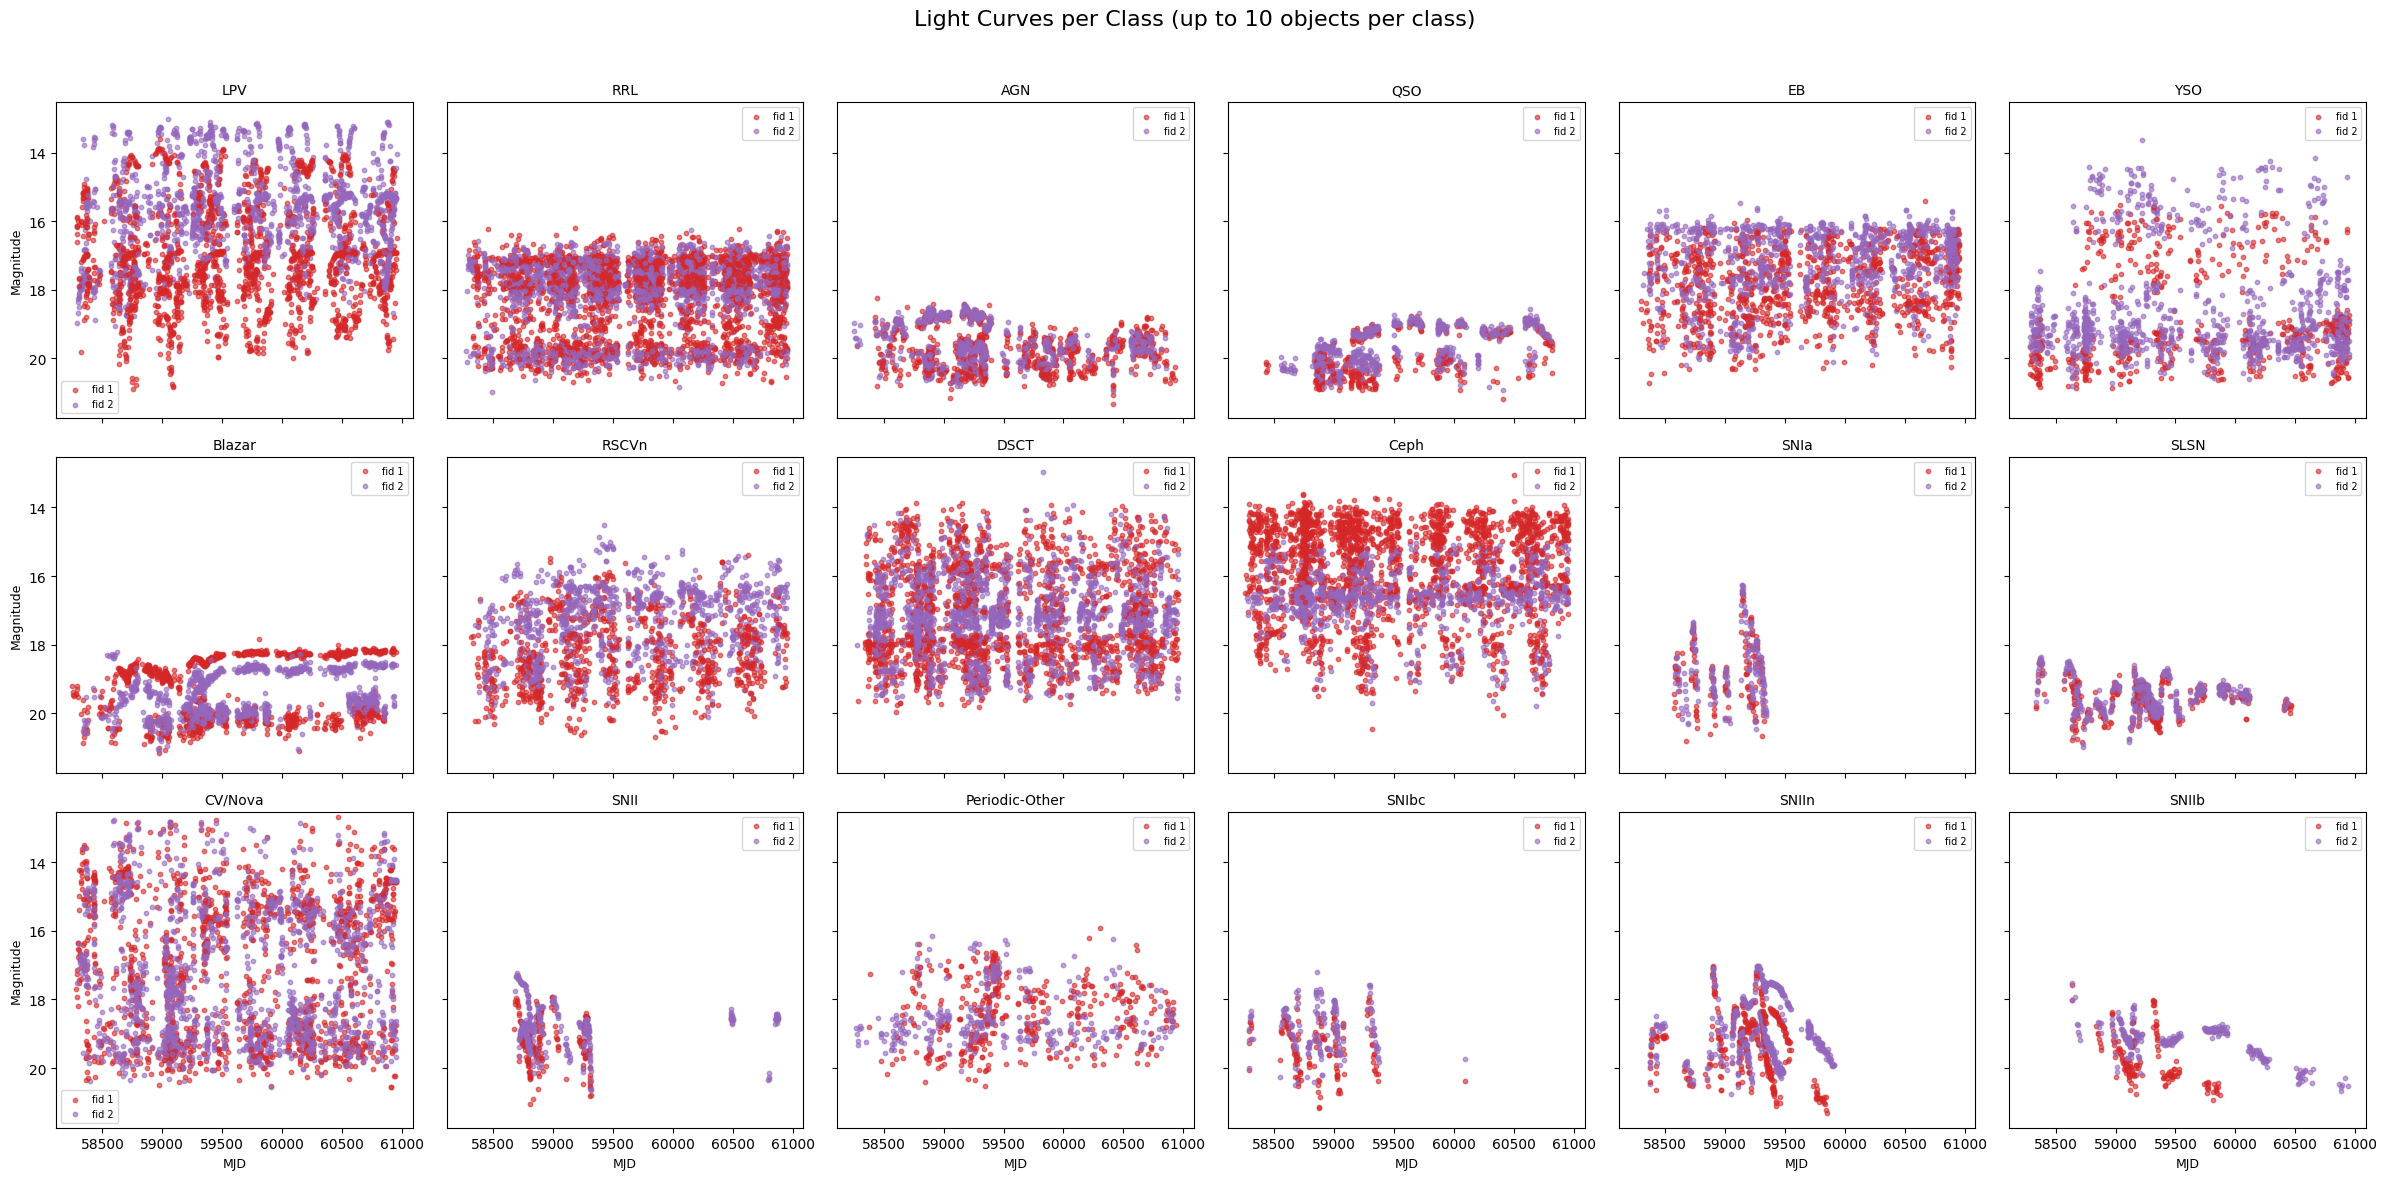

In [13]:
fid_colors = {1: "tab:red", 2: "tab:purple", 3: "tab:yellow"}
max_per_class = 10

classes_unique = y.unique()
sample_oids_per_class = {}
all_sample_oids = []

# Select sample OIDs 
for cls in classes_unique:
    oids_cls = y[y == cls]
    n_sample = min(max_per_class, len(oids_cls))
    sampled = oids_cls.sample(n_sample, random_state=42).index.tolist()
    sample_oids_per_class[cls] = sampled
    all_sample_oids.extend(sampled)

# Global limits
mjd_min, mjd_max = np.inf, -np.inf
mag_min, mag_max = np.inf, -np.inf
for oid in all_sample_oids:
    try:
        df_det = alerce.query_detections(oid, format='pandas')
        mags = df_det['magpsf'].dropna()
        mjds = df_det['mjd'].dropna()
        if len(mags) == 0 or len(mjds) == 0:
            continue
        mag_min = min(mag_min, mags.min())
        mag_max = max(mag_max, mags.max())
        mjd_min = min(mjd_min, mjds.min())
        mjd_max = max(mjd_max, mjds.max())
    except:
        continue

mag_range = mag_max - mag_min
y_lim_lower = mag_max + 0.05*mag_range
y_lim_upper = mag_min - 0.05*mag_range

mjd_range = mjd_max - mjd_min
x_lim_left = mjd_min - 0.05*mjd_range
x_lim_right = mjd_max + 0.05*mjd_range

# 3x6 subplot grid
fig, axes = plt.subplots(3, 6, figsize=(24, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, cls in enumerate(classes_unique):
    ax = axes[i]
    sample_oids = sample_oids_per_class.get(cls, [])
    
    for oid in sample_oids:
        try:
            df_det = alerce.query_detections(oid, format='pandas')
            for fid in sorted(df_det['fid'].unique()):
                mask = df_det['fid'] == fid
                if df_det.loc[mask, 'magpsf'].dropna().size == 0:
                    continue
                ax.scatter(df_det.loc[mask, 'mjd'], df_det.loc[mask, 'magpsf'],
                           s=10, color=fid_colors.get(fid, "gray"), alpha=0.6, label=f"fid {fid}")
        except:
            continue

    # Legends with no dupes
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=7)
    
    ax.set_title(f"{cls}", fontsize=10)
    ax.invert_yaxis()
    ax.set_xlim(x_lim_left, x_lim_right)
    ax.set_ylim(y_lim_lower, y_lim_upper)

# Final configs
for ax in axes[-6:]:  
    ax.set_xlabel("MJD", fontsize=9)
for ax in axes[::6]: 
    ax.set_ylabel("Magnitude", fontsize=9)

plt.suptitle("Light Curves per Class (up to 10 objects per class)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The light curve plots show how each object’s brightness (magnitude) varies over time, measured in Modified Julian Date (MJD). The y-axis represents apparent magnitude, where lower values indicate higher brightness. Different colors correspond to photometric filters (mainly g, r and i bands). Some objects appear in only some filters due to observational limits or low brightness in other bands. These curves reveal characteristic variability patterns that distinguish each astrophysical class.

Now we will aim to visually inspect the light curves of 30 randomly selected objects from the dataset. By plotting each object separately, we can explore the diversity of brightness variations over time and observe potential patterns or behaviors in their luminosity. This approach provides an intuitive understanding of the variability present in the data before applying automated classification methods.

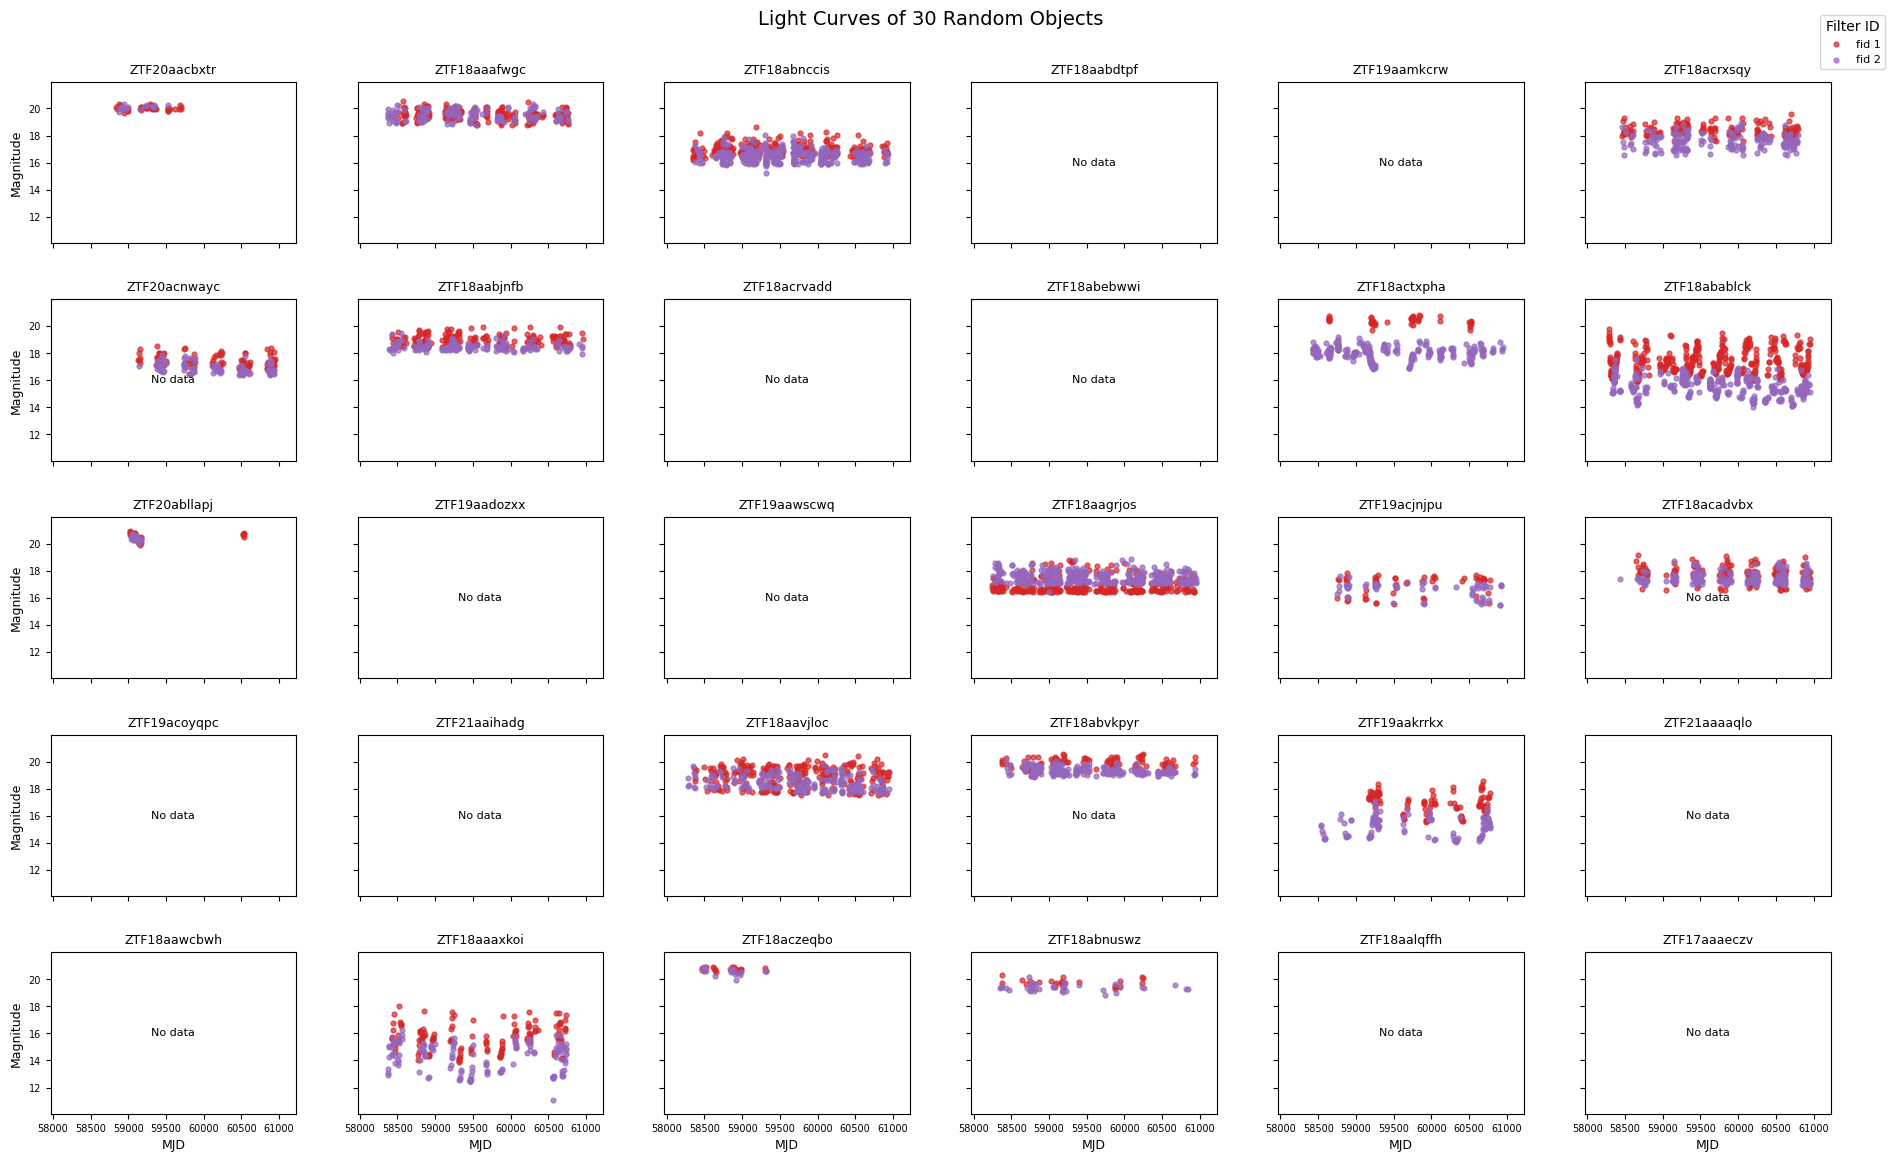

In [14]:
# Select 30 random objects
sample_oids = y.sample(30, random_state=42).index.tolist()

fid_colors = {1: "tab:red", 2: "tab:purple", 3: "tab:yellow"}

# Create plot with appropriate size
fig, axes = plt.subplots(5, 6, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Global limits
mag_min, mag_max = np.inf, -np.inf
mjd_min, mjd_max = np.inf, -np.inf
for oid in sample_oids:
    try:
        df_det = alerce.query_detections(oid, format='pandas')
        mags = df_det['magpsf'].dropna()
        mjds = df_det['mjd'].dropna()
        if len(mags) == 0 or len(mjds) == 0:
            continue
        mag_min = min(mag_min, mags.min())
        mag_max = max(mag_max, mags.max())
        mjd_min = min(mjd_min, mjds.min())
        mjd_max = max(mjd_max, mjds.max())
    except:
        continue

# Add margin
mag_range = mag_max - mag_min
y_margin = mag_range * 0.1
y_lim_lower = mag_max + y_margin
y_lim_upper = mag_min - y_margin

mjd_range = mjd_max - mjd_min
x_margin = mjd_range * 0.1
x_lim_left = mjd_min - x_margin
x_lim_right = mjd_max + x_margin

# Graph in subplots
for i, oid in enumerate(sample_oids):
    ax = axes[i]
    try:
        df_det = alerce.query_detections(oid, format='pandas')
        for fid in sorted(df_det['fid'].unique()):
            mask = df_det['fid'] == fid
            if df_det.loc[mask, 'magpsf'].dropna().size == 0:
                continue
            ax.scatter(df_det.loc[mask, 'mjd'], df_det.loc[mask, 'magpsf'],
                       s=12, color=fid_colors.get(fid, "gray"), alpha=0.7, label=f"fid {fid}")
    except:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=8)

    # Uniform axis
    ax.set_xlim(x_lim_left, x_lim_right)
    ax.set_ylim(y_lim_lower, y_lim_upper)
    ax.invert_yaxis()
    ax.set_title(f"{oid}", fontsize=9)
    ax.tick_params(axis='both', which='major', labelsize=7)

# Move legend so it doesn't cover data
handles, labels = axes[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), 
           loc='upper right', fontsize=8, title="Filter ID", 
           bbox_to_anchor=(0.98, 0.98))

# Label config
for ax in axes[-6:]:  
    ax.set_xlabel("MJD", fontsize=9)
for ax in axes[::6]:  
    ax.set_ylabel("Magnitude", fontsize=9)

plt.suptitle("Light Curves of 30 Random Objects", fontsize=14, y=0.98)

plt.subplots_adjust(left=0.06, right=0.95, top=0.92, bottom=0.06, 
                    hspace=0.35, wspace=0.25)
plt.show()

From the plots, it becomes clear that visually classifying the objects based solely on their light curves is challenging. Many curves appear similar or exhibit subtle differences that are difficult to discern by eye, making manual classification unreliable. This highlights the importance of advanced tools such as machine learning algorithms, which can systematically detect patterns and classify astronomical objects with greater accuracy and consistency.

## Model training

After exploring and visualizing the dataset, the next step is to develop models capable of automatically classifying astronomical objects based on their observed features. While visual inspection can sometimes reveal patterns, it quickly becomes impractical and subjective when dealing with large-scale surveys such as ZTF or LSST, where millions of light curves are collected.

Therefore, applying **machine learning algorithms** allows us to build models that learn from data and generalize to unseen examples, providing a systematic and scalable approach to classification.

In this section, we will train and compare several models with different learning paradigms:

* K-Nearest Neighbors (KNN), a simple instance-based classifier that relies on feature proximity.

* Decision Trees and Random Forests, which are powerful ensemble methods that capture nonlinear patterns and feature interactions.

* Logistic Regression, a probabilistic approach to bring diversity.

Together, these methods allow us to evaluate how well supervised approaches can identify variable objects and understand the separability of their feature space.

Before training any machine learning model, it is crucial to properly split the dataset into **training** and **test sets**. This separation allows us to train the model on one portion of the data while reserving the other portion to evaluate its performance on unseen objects. Using a stratified split ensures that the distribution of classes remains consistent between training and test sets, which is especially important when dealing with imbalanced astronomical classes.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} objects")
print(f"Test set size: {X_test.shape[0]} objects")

Training set size: 27286 objects
Test set size: 11695 objects


The dataset was divided such that **70% of the objects** are used for training the model and **30% for testing** its predictive performance. This ensures that the model learns from a representative portion of the data while being evaluated on independent samples, providing a realistic estimate of its ability to generalize to new, unseen astronomical objects. The stratification guarantees that all classes are proportionally represented in both subsets, avoiding bias toward more frequent classes.

Now we will train and evaluate our machine learning models to classify astronomical objects based on their photometric features.

In [16]:
# Define the pipeline (no scaler, since data is already scaled)
pipeline_knn = Pipeline([
    ("knn", KNeighborsClassifier())
])

# Define hyperparameter grid
param_grid_knn = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"]
}

# Define stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV 
grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    cv=cv,
    n_jobs=-1,
    verbose=1 
)

# Fit the model
grid_knn.fit(X_train, y_train)

# Display results
print("🔹 Best KNN parameters:", grid_knn.best_params_)
print("🔹 Best cross-validation accuracy:", grid_knn.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
🔹 Best KNN parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
🔹 Best cross-validation accuracy: 0.8616874134989079


In [17]:
# Subsample the training data for hyperparameter search
X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train, train_size=0.2, stratify=y_train, random_state=42
)

# Random Forest hyperparameter distribution
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']  # handle class imbalance
}

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search with 10 iterations to keep runtime reasonable
rf = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=10, cv=skf, scoring='accuracy',
    random_state=42, n_jobs=1, verbose=0
)

# Fit on subsample
random_search_rf.fit(X_sub, y_sub)

# Best hyperparameters and CV score
print("🔹 Best RF parameters:", random_search_rf.best_params_)
print("🔹 Best CV accuracy:", random_search_rf.best_score_)

🔹 Best RF parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': 'balanced'}
🔹 Best CV accuracy: 0.880520609851499


In [18]:
# Logistic Regression simplified
logreg = LogisticRegression(max_iter=500, multi_class='ovr', n_jobs=-1)

# Stratified K-Fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid of hyperparameters
param_grid = {
    'C': [0.1, 1],
    'solver': ['liblinear'],
    'penalty': ['l2']
}

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

# Fit the model
grid_search.fit(X_train, y_train)

# Results
print(f"🔹 Best Logistic Regression parameters: {grid_search.best_params_}")
print(f"🔹 Best CV accuracy: {grid_search.best_score_:.4f}\n")

🔹 Best Logistic Regression parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
🔹 Best CV accuracy: 0.8771



We can see that all three models achieve high overall accuracy (~0.86–0.88) on the dataset. Random Forest performs slightly better overall. Across all models, the main challenge could possibly be the **class imbalance**, which reduces performance on underrepresented classes. Forward, we will look at metrics so we can accurately confirm our hypothesis.

## Model Metrics


Now we will evaluate the performance of our trained classifiers using **Receiver Operating Characteristic (ROC) curves**. These curves allow us to visualize the trade-off between true positive and false positive rates across different thresholds, providing an intuitive way to compare model performance. By analyzing the **Area Under the Curve (AUC)**, we can assess how well each classifier distinguishes between the different variable star classes, offering a robust metric for model comparison beyond simple accuracy

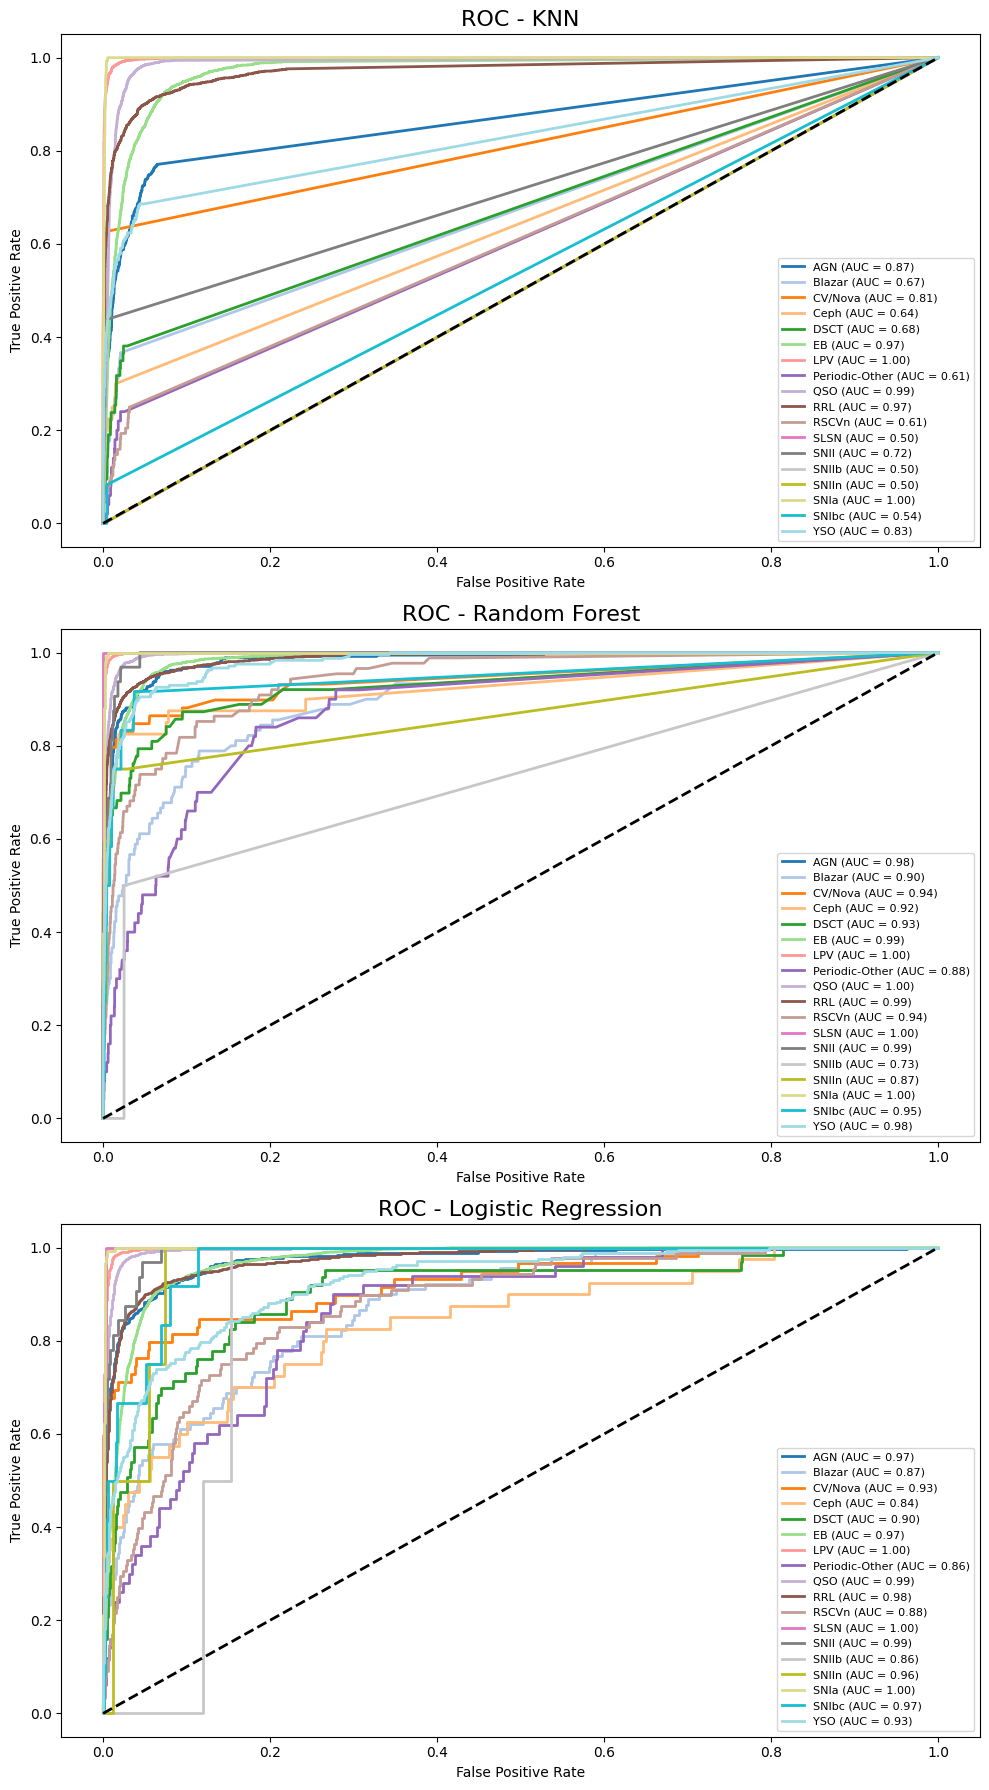

In [19]:
# Dataset name list
class_names = np.unique(y) 

# Binerize labels for multiclass
y_test_bin = label_binarize(y_test, classes=class_names)
n_classes = y_test_bin.shape[1]

# Best KNN model with known best parameters
best_knn = KNeighborsClassifier(
    n_neighbors=7,
    weights='distance',
    metric='manhattan'
)

# Best RF model with known best parameters
best_rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

# Best Logistic Regression model with known best parameters
best_lr = LogisticRegression(
    C=1,
    penalty='l2',
    solver='liblinear',
    random_state=42
)

# Fit on the full training set
best_knn.fit(X_train, y_train)
best_rf.fit(X_train, y_train)
best_lr.fit(X_train, y_train)

# Classifier dictionary
classifiers = {
    "KNN": best_knn,
    "Random Forest": best_rf,
    "Logistic Regression": best_lr
}

# Subplot config
fig, axes = plt.subplots(len(classifiers), 1, figsize=(10, 6 * len(classifiers)))
colors = plt.cm.get_cmap('tab20', n_classes)

for ax, (name, clf) in zip(axes, classifiers.items()):
    # Predict probabilities
    y_score = clf.predict_proba(X_test)
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=colors(i), lw=2,
                label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal
    ax.set_title(f"ROC - {name}", fontsize=16)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()


The ROC curve analysis shows clear differences in performance among the classifiers. **Random Forest** achieves the best results, with ROC curves close to the top-left corner and high AUC values, reflecting strong class separation. **Logistic Regression** performs slightly worse but still consistently, with more stepped curves due to its linear nature. In contrast, **K-Nearest Neighbors (KNN)** shows the weakest performance, with lower AUC values and curves near the diagonal, indicating difficulty in handling complex and imbalanced data. Overall, ensemble-based models like Random Forest prove to be the most effective for this classification task.

After evaluating the classifiers using ROC curves, we turn to confusion matrices to gain a more detailed view of their performance. Confusion matrices show how many instances of each true class are correctly or incorrectly predicted, highlighting specific strengths and weaknesses of the models. They are particularly useful for identifying which classes are often misclassified, which is important in imbalanced datasets like ours where some astronomical object types are much rarer than others.

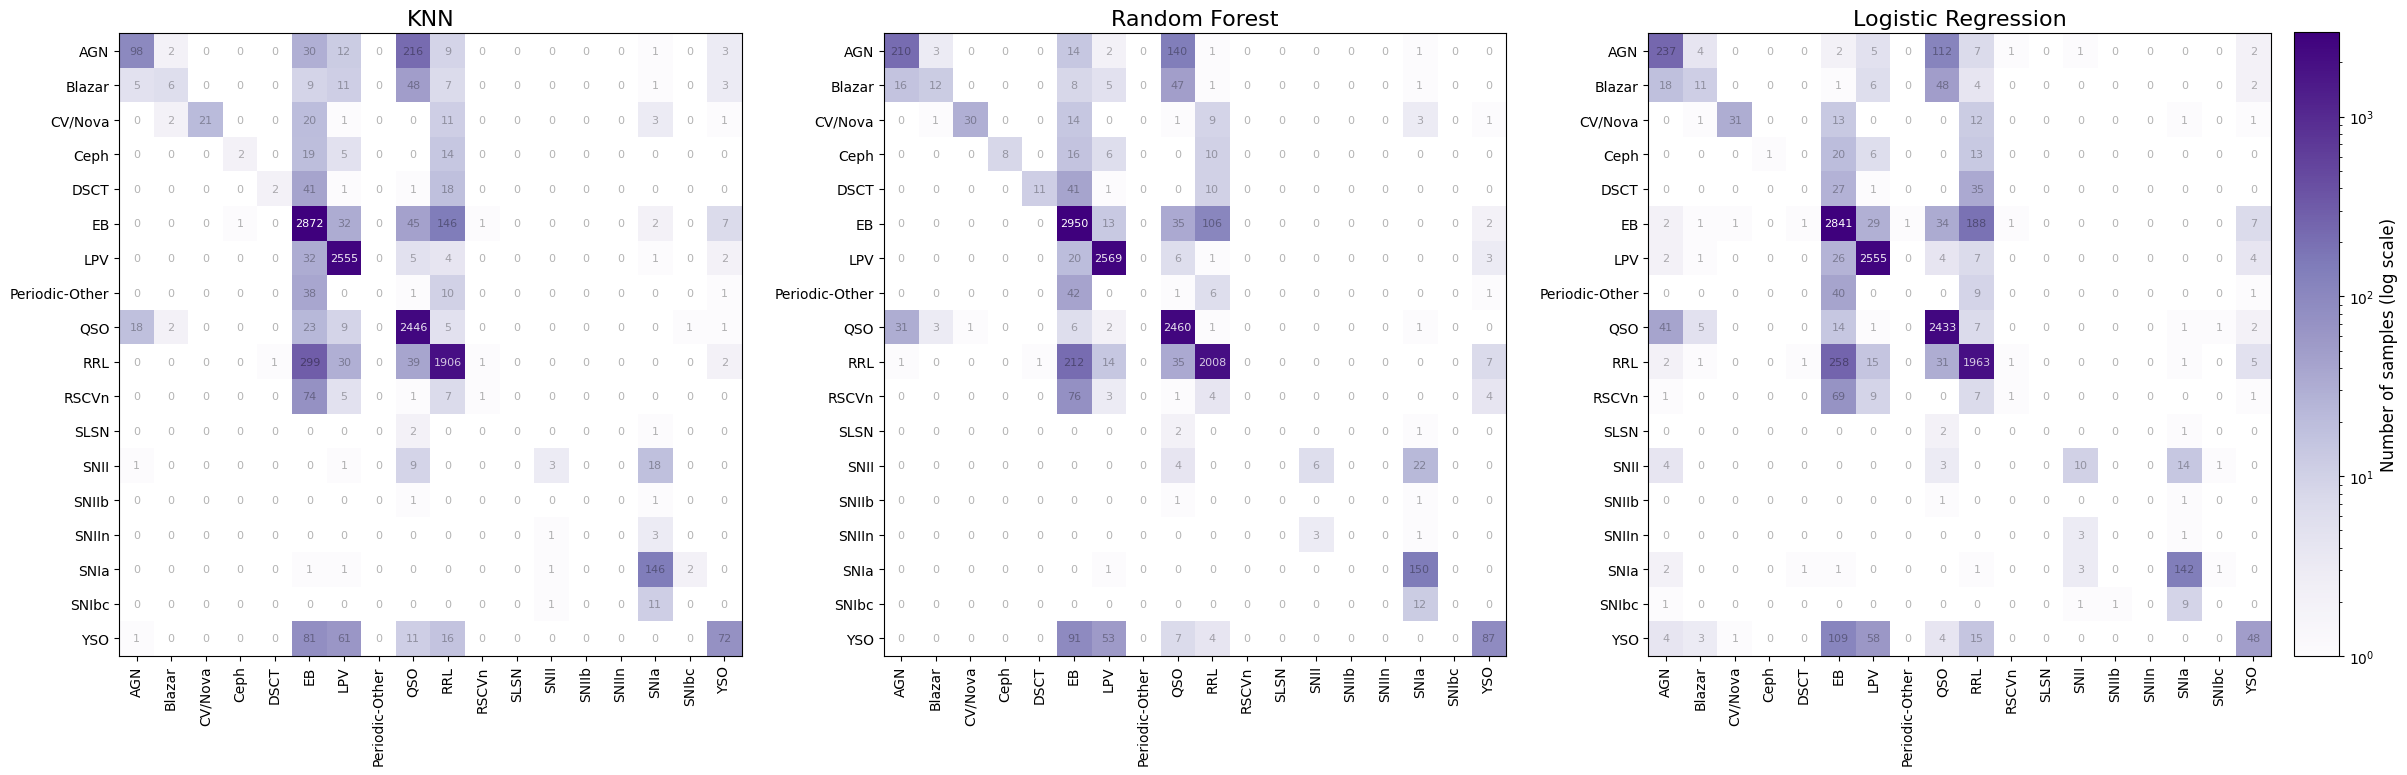

In [20]:
# Gridspec config
fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.3)

# Shared log-normalization
vmin = 1
vmax = max(confusion_matrix(y_test, clf.predict(X_test)).max() for clf in classifiers.values())
norm = LogNorm(vmin=vmin, vmax=vmax)

for i, (name, clf) in enumerate(classifiers.items()):
    ax = fig.add_subplot(gs[i])
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    
    im = ax.imshow(cm, interpolation='nearest', cmap='Purples', norm=norm)
    
    # Opacity
    for r in range(cm.shape[0]):
        for c in range(cm.shape[1]):
            val = cm[r, c]
            alpha = 0.3 + 0.7*(val/cm.max())
            ax.text(c, r, val,
                    ha='center', va='center',
                    color='white' if val > cm.max()/2 else 'black',
                    fontsize=8,
                    alpha=alpha)
    
    ax.set_title(name, fontsize=16)
    ax.set_xticks(np.arange(len(np.unique(y))))
    ax.set_yticks(np.arange(len(np.unique(y))))
    ax.set_xticklabels(np.unique(y), rotation=90)
    ax.set_yticklabels(np.unique(y))

# Color bar
cax = fig.add_axes([0.85, 0.1835, 0.015, 0.624])  # x0, y0, width, height
fig.colorbar(im, cax=cax)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Number of samples (log scale)', fontsize=12)

plt.show()

The confusion matrices show that the classifiers generally perform well on the dominant classes, such as LPV, EB, and QSO, where both precision and recall are high. However, for underrepresented classes—like supernova types (SLSN, SNIIb, SNIIn, SNIbc) and other rare variable stars—the models often fail to predict them correctly. In many cases, instances of these minority classes are misclassified into the more common categories, effectively “losing” their original label. This phenomenon once again highlights the **severe class imbalance** in the dataset: the classifiers tend to favor the frequent classes and underrepresent the rare ones. As a result, although the overall accuracy remains high, the models do not generalize well to minority categories, leading to poor recall and precision for these rare classes.

To complement the visual evaluation provided by the ROC curves and confusion matrices, it is essential to compute aggregated metrics such as accuracy, precision, recall, and F1-score. These summary statistics allow us to quantify the overall performance of each classifier, considering both majority and minority classes. By analyzing micro and macro averages, we can better understand how well the models generalize across the entire dataset and how the imbalance among classes affects their predictive capabilities. This provides a concise yet comprehensive view of the strengths and weaknesses of each approach.

In [21]:
# Dictionary to store results
metrics_summary = {}

for name, clf in classifiers.items():
    y_pred = clf.predict(X_test)
    
    metrics_summary[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (macro)": precision_score(y_test, y_pred, average='macro', zero_division=0),
        "Precision (micro)": precision_score(y_test, y_pred, average='micro', zero_division=0),
        "Recall (macro)": recall_score(y_test, y_pred, average='macro', zero_division=0),
        "Recall (micro)": recall_score(y_test, y_pred, average='micro', zero_division=0),
        "F1-score (macro)": f1_score(y_test, y_pred, average='macro', zero_division=0),
        "F1-score (micro)": f1_score(y_test, y_pred, average='micro', zero_division=0)
    }

# Show results
pd.DataFrame(metrics_summary).T

,Accuracy,Precision (macro),Precision (micro),Recall (macro),Recall (micro),F1-score (macro),F1-score (micro)
KNN,0.866182,0.529068,0.866182,0.325494,0.866182,0.348218,0.866182
Random Forest,0.897905,0.568733,0.897905,0.384699,0.897905,0.420000,0.897905
Logistic Regression,0.878410,0.497400,0.878410,0.361378,0.878410,0.380685,0.878410


As we can see, Random Forest achieves the highest overall performance, balancing some accuracy across both common and rare classes. Logistic Regression performs slightly worse, while KNN struggles with underrepresented categories. These results highlight the impact of the class imbalance, as models tend to favor the most frequent classes.

This study provided valuable insights into the strengths and limitations of different classifiers. We learned how model choice interacts with class imbalance, affecting the recognition of rare categories. Future improvements could focus on better handling minority classes through resampling, weighting, or ensemble strategies, highlighting that careful dataset management is as crucial as algorithm selection for robust classification.